In [39]:
%matplotlib inline
import warnings
from random import shuffle
from time import time
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost.callback import reset_learning_rate
from itertools import product
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
idx = pd.IndexSlice
np.random.seed(42)

## Helper Functions

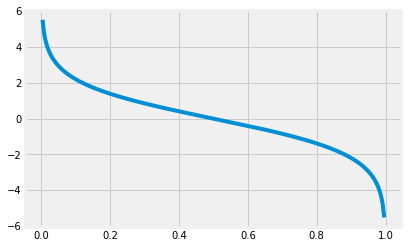

In [91]:
err = np.linspace(0, 1, 250)
r = np.log((1-err)/err)
pd.Series(r, index=err).plot();

In [47]:
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'

In [4]:
def get_data(start='2000', end='2018', holding_period=1, dropna=False):
    idx = pd.IndexSlice
    target = f'target_{holding_period}m'
    with pd.HDFStore('data.h5') as store:
        df = store['data']

    if start is not None and end is not None:
        df = df.loc[idx[:, start: end], :]
    if dropna:
        df = df.dropna()

    y = (df[target] > 0).astype(int)
    X = df.drop([c for c in df.columns if c.startswith('target')], axis=1)
    return y, X

In [5]:
def get_one_hot_data(df, cols=('year', 'month', 'age', 'msize')):
    cols = list(cols)
    df = pd.get_dummies(df,
                        columns=cols + ['sector'],
                        prefix=cols + [''],
                        prefix_sep=['_'] * len(cols) + [''])
    return df.rename(columns={c: c.replace('.0', '').replace(' ', '_').lower() for c in df.columns})

In [6]:
def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(target.index.get_level_values('date').unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start: cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start: holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

In [7]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle
        self.test_end = n_splits * test_period_length

    @staticmethod
    def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index
                        .get_level_values('date')
                        .unique()
                        .sort_values(ascending=False)
                        [:self.test_end])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

## Adaptive Learning

In [8]:
def learning_rate(n, ntot):
    start_eta = 0.1
    k = 8 / ntot
    x0 = ntot / 1.8
    return start_eta * (1 - 1 / (1 + np.exp(-k * (n - x0))))

## Get Data

In [20]:
def get_datasets(features, target, kfold):
    cat_cols = ['year', 'month', 'age', 'msize', 'sector']
    data = {}
    for fold, (train_idx, test_idx) in enumerate(kfold.split(features)):
        print(fold, end=' ', flush=True)

        data[fold] = {'train': xgb.DMatrix(label=target.iloc[train_idx],
                                           data=features.iloc[train_idx],
                                           nthread=-1),
                      'valid': xgb.DMatrix(label=target.iloc[test_idx],
                                           data=features.iloc[test_idx],
                                           nthread=-1)}
    return data     

## Train-Test Loop

In [45]:
def run_cv(test_params, data, n_splits=12):
    """Train-Validate with early stopping"""
    result = []
    cols = ['rounds', 'train', 'valid']
    for fold in range(n_splits):
        train = data[fold]['train']
        valid = data[fold]['valid']

        scores = {}

        model = xgb.train(params=test_params,
                          dtrain=train,
                          evals=list(zip([train, valid], ['train', 'valid'])),
                          verbose_eval=False,
                          num_boost_round=250,
                          early_stopping_rounds=25,
                          evals_result=scores)

        result.append([model.best_iteration,
                       scores['train']['auc'][-1],
                       scores['valid']['auc'][-1]])

    df = pd.DataFrame(result, columns=cols)
    return (df
            .mean()
            .append(df.std().rename({c: c + '_std' for c in cols}))
            .append(pd.Series(test_params)))

## Baseline Parameters

In [75]:
params = dict(
    booster='gbtree',
    objective='binary:logistic',
    eval_metric=['logloss', 'auc'],
    tree_method='hist',
    max_depth=6,
    learning_rate=0.3,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=1,
    colsample_bytree=1,
    colsample_bylevel=1,
    reg_alpha=0,
    reg_lambda=1,
    silent=1,
    seed=42,
)

## Setup

In [76]:
HOLDOUT = True
n_splits = 12
result_key = f'/xgboost/results'

In [77]:
y, X = get_data()
X = get_one_hot_data(X)

In [78]:
y, X, y_test, X_test = get_holdout_set(target=y, features=X)

In [79]:
cv = OneStepTimeSeriesSplit(n_splits=n_splits)

In [21]:
datasets = get_datasets(features=X, target=y, kfold=cv)

0 1 2 3 4 5 6 7 8 9 10 11 

In [80]:
results = pd.DataFrame()

In [81]:
with pd.HDFStore('results.h5') as store:
    cv_result = store['xgboost/dummies']
print(cv_result.head(10))

      rounds     train     valid booster  learning_rate  gamma  max_depth  \
0  59.166667  0.798142  0.683618  gbtree            0.1      1          9   
1  59.166667  0.798142  0.683618  gbtree            0.1      5          9   
2  59.166667  0.798142  0.683618  gbtree            0.1      0          9   
3  47.666667  0.790726  0.681356    dart            0.1      1          9   
4  47.666667  0.790726  0.681356    dart            0.1      5          9   
5  47.666667  0.790726  0.681356    dart            0.1      0          9   
6  53.833333  0.847023  0.679781  gbtree            0.1      0         11   
7  53.833333  0.847023  0.679781  gbtree            0.1      1         11   
8  53.833333  0.847023  0.679781  gbtree            0.1      5         11   
9  44.583333  0.790091  0.679346    dart            0.1      0          9   

   colsample_bytree        time  
0               1.0   85.372013  
1               1.0   94.299514  
2               1.0   75.323257  
3               

In [ ]:
test_params = ['booster', 'learning_rate', 'gamma', 'max_depth', 'colsample_bytree']

## Parameter Grid

In [86]:
param_grid = dict(
        learning_rate=[.1],
        max_depth=[9],
        booster=['gbtree'],
        gamma=[10, 20, 50],
        colsample_bytree=[1])

In [87]:
all_params = list(product(*param_grid.values()))
shuffle(all_params)
n_models = len(all_params)
print(f'# Models: {n_models:,d}')

# Models: 3


In [88]:
display_cols = ['rounds', 'time', 'valid', 'valid_std', 'train'] + list(param_grid.keys())

In [89]:
start = time()
results = pd.DataFrame()
for n, test_param in enumerate(all_params, 1):
    iteration = time()
    cv_params = params.copy()
    cv_params.update(dict(zip(param_grid.keys(), test_param)))

    results[n] = run_cv(test_params=cv_params,
                        data=datasets,
                        n_splits=n_splits)
    results.loc['time', n] = time() - iteration

    print('\n')
    print(results.loc[display_cols, :].T.sort_values('valid', ascending=False).head(5).reset_index(drop=True))
    out = f'\n\tModel: {n} of {n_models} | '
    out += f'{format_time(time() - iteration)} | '
    out += f'Total: {format_time(time() - start)} | '
    print(out + f'Remaining: {format_time((time() - start)/n*(n_models-n))}\n')

[12:35:34] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[12:35:46] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[12:35:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[12:36:02] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[12:36:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[12:36:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[12:36:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[12:36:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[12:37:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[12:37:04] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[12:37:09] Tree meth

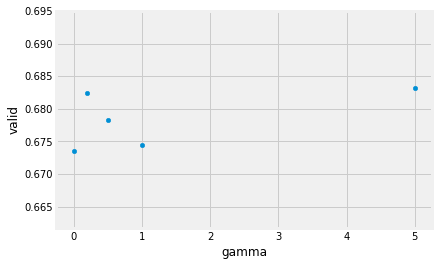

In [73]:
results.T.apply(pd.to_numeric, errors='ignore').plot.scatter(x='gamma', y='valid');

In [74]:
with pd.HDFStore('xgboost_tests.h5') as store:
    store.put('params/gamma', results)